In [521]:
import pandas as pd
import re
import os
import requests
from shapely.geometry import Point, Polygon
from geopy.geocoders import Nominatim
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np

dataframe = pd.read_csv("wggesucht_scraped_24_05.csv")
dataframe = dataframe

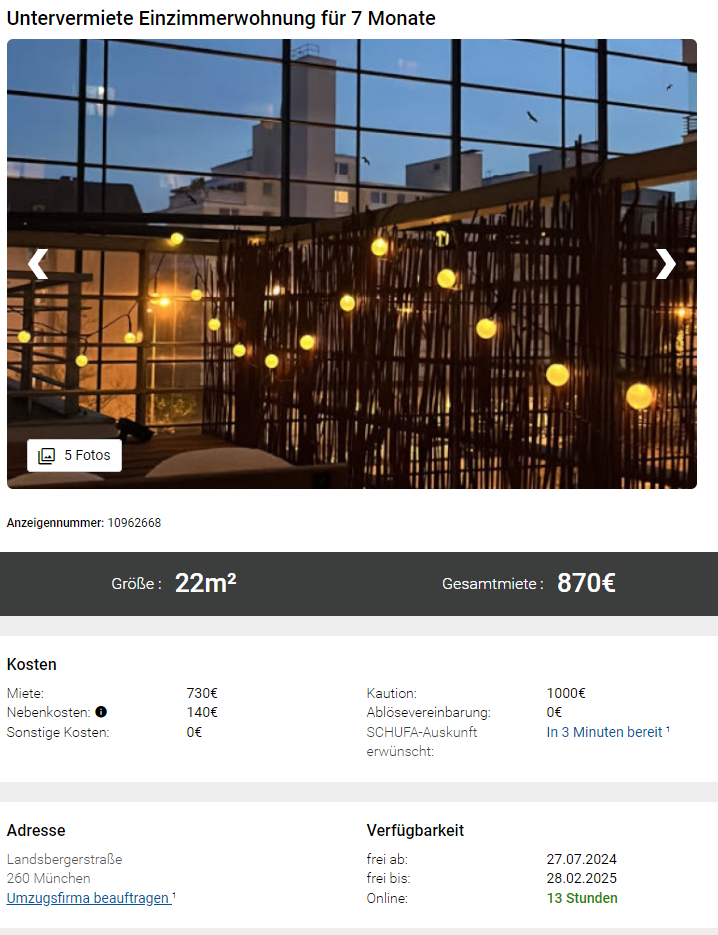  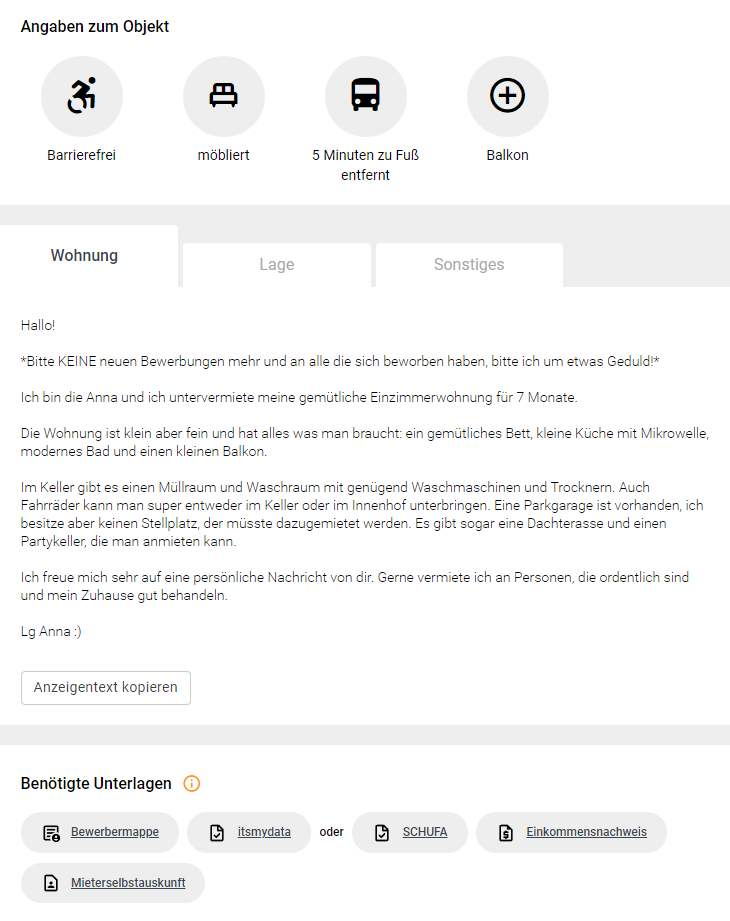

In [522]:
display(dataframe)

,Url,Title,Size,PriceTotal,Price,ExtraCosts,OtherCosts,Deposit,RedemptionAgreement,DateFree,...,OnlineSince,Adress,Details,LookingFor,AmountofIcons,AmountofIconsNeeded,DescriptionRoom,DescriptionLocation,DescriptionLife,description_other
0,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,Room in a WG of 4 close to Freimann U6,12m²,670€,670€,n.a.,n.a.,n.a.,n.a.,01.07.2024,...,32 Minuten,Freisinger Landstr. 18\n ...,12m²\n \n ...,Geschlecht egal\n ...,3,n.a.,"The room is furnished with desk, bed and wardr...",Very close to the Freimann stop (U6). Buses 18...,You will be sharing the apartment with me (Ita...,"The kitchen, which is a separate room in the a..."
1,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,Beste Lage - Zimmer frei bei Studentenverbindung,20m²,350€,350€,n.a.,0€,600€,0€,24.05.2024,...,6 Minuten,Königinstr. 20\n ...,20m²\n \n ...,Mann\n ...,12,n.a.,Du wirst demnächst Dein Studium an der LMU/TU ...,Top Lage direkt am Englischen Garten - Zweimal...,"Wir sind ein ""Corps"", eine Art von Studentenv...","Da wir besonderen Wert darauf legen, dass wir ..."
2,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,TOP LAGE - U3 Nahe Olympia-Einkaufszentrum,11m²,790€,740€,50€,0€,2200€,0€,24.05.2024,...,37 Minuten,Seydlitzstraße 63\n ...,11m²\n \n ...,Geschlecht egal\n,8,4,Gemütliches WG Zimmer voll möbliert mit Bett m...,"Sehr gute Lage, Bus-und U-Bahn-Haltestellen na...",Gemischte Wohngemeinschaft mit Studenten und B...,Verfügbar ab sofort.
3,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,TOP UNI LOCATION near U3/U6: Münchner Freiheit,14m²,970€,911€,59€,0€,2673€,0€,01.08.2024,...,37 Minuten,Germaniastraße 3\n ...,14m²\n \n ...,Geschlecht egal\n,7,3,"Schlafzimmer ist voll Möbliert (Bett, Schrank,...",Die Wohnung befindet sich in einer spitzen Lag...,4 junge Männer Anfang 20 Jahre. \n\r\n Gemeins...,Bitte kontaktieren Sie uns über WG-Gesucht. \r...
4,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,+++ WG-Zimmer in renovierter 4er WG verfügbar!...,14m²,800€,715€,85€,0€,2145€,0€,01.07.2024,...,39 Minuten,Schlierseestraße 14\n ...,14m²\n \n ...,Geschlecht egal\n,12,5,Wunderschönes Zimmer in 4er WG ab dem 01.07.20...,Die Schlierseestraße 14 liegt in einer attrakt...,Willkommen in unserer charmanten WG in München...,Link zum Wohnungs-Bewerbungsformular (Aplicati...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,Wohngemeinschaft in München,108m²,1220€,1220€,n.a.,n.a.,1830€,n.a.,05.08.2024,...,17.05.2024,Tumblingerstraße Glockenbachviertel 17\n ...,108m²\n \n ...,Geschlecht egal\n,3,n.a.,Wohnen Sie nur wenige Schritte von der Isar en...,munich,n.a.,**Bitte beachten: PAARE** sind nur in Schlafzi...
1131,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,Zimmer zu vermieten in 4-Zimmer-Wohnung in der...,n.a.,1325€,1325€,n.a.,n.a.,1000€,n.a.,24.05.2024,...,17.05.2024,Heßstraße 74\n ...,Zimmer in 2er WG\nWohnungsgröße: 1m²\n2er WG\n...,Geschlecht egal\n,4,n.a.,Zimmer zu vermieten in 4-Zimmer-Wohnung in der...,munich,n.a.,**Dieser Vermieter akzeptiert keine Studenten!...
1132,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,(Verfügbar 1-24 Monate) - Privatzimmer in Laim...,12m²,1020€,1020€,n.a.,n.a.,n.a.,n.a.,19.08.2024,...,1 Tag,Tübinger Straße 3c\n ...,12m²\n \n ...,Geschlecht egal\n,4,n.a.,- Handtücher und Bettlaken \n - Hygieneutensil...,Homelike ist eine Online-Buchungsplattform für...,n.a.,Homelike Code: UBK-896965
1133,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,(Verfügbar 1-24 Monate) - Private Room in Unte...,14m²,960€,960€,n.a.,n.a.,n.a.,n.a.,05.08.2024,...,1 Tag,Grünwalderstraße 119\n ...,14m²\n \n ...,Geschlecht egal\n,4,n.a.,- Handtücher und Bettlaken \n - Hygieneutensil...,Homelike ist eine Online-Buchungsplattform für...,n.a.,Homelike Code: UBK-380836


Shape the data to be able to do a regression analysis

1. Idea: If the length of a title is too short, it might not be as appealing or the advert isn't made well hence price might be lower therefore a longer title might indicate a higher price (vgl. outbrain o.J., o.S.) => same procedure for looking for

In [523]:
dataframe['Title_length'] = dataframe['Title'].str.len()
dataframe['LookingFor_length'] = dataframe['LookingFor'].str.len()

2. Idea: The size of the WG is highly correlated with the pricing. (in source rooms of houses: (vgl. Zhang 2021, S. 6f)) - clean up of unnessesary characters

In [524]:
dataframe['Size'] = dataframe['Size'].str.replace(r'\D+', '', regex=True)

3. Idea: Relevant is only the total (monthly) price and the initial deposit - others are discarded.

In [525]:
# Remove columns
dataframe = dataframe.drop(['Price', 'ExtraCosts', 'OtherCosts'], axis=1)

columns_to_replace = ['RedemptionAgreement', 'DateFreeTill']
dataframe[columns_to_replace] = dataframe[columns_to_replace].replace('n.a.', 0)

# Remove '€' symbol from 'PriceTotal' and 'Deposit' columns
dataframe['PriceTotal'] = dataframe['PriceTotal'].str.replace('€', '')
dataframe['Deposit'] = dataframe['Deposit'].str.replace('€', '')


4. Idea: Transform the column onlineSince to hours - or an esitamte based on the onlineSince value (e.g. when the advert was 1 day online => 24 hours)

In [526]:
dataframe['OnlineSince'] = dataframe['OnlineSince'].astype(str)

# Function to transform the values in the "OnlineSince" column
def transform_online_since(row):
    if 'Minuten' in row:
        return 1
    elif 'Stunde' in row:
        return 1
    elif 'Stunden' in row:
        return int(''.join(filter(str.isdigit, row)))
    elif 'Tag' in row:
        return 24
    else:
        refering_date = pd.to_datetime('24.05.2024', format='%d.%m.%Y')
        date = pd.to_datetime(row, format='%d.%m.%Y')
        hours_difference = (refering_date - date).total_seconds() / 3600
        return hours_difference

# Apply the transformation function to the "OnlineSince" column
dataframe['OnlineSince'] = dataframe['OnlineSince'].apply(transform_online_since)


intermediate state of dataframe

In [527]:
display(dataframe)

,Url,Title,Size,PriceTotal,Deposit,RedemptionAgreement,DateFree,DateFreeTill,OnlineSince,Adress,Details,LookingFor,AmountofIcons,AmountofIconsNeeded,DescriptionRoom,DescriptionLocation,DescriptionLife,description_other,Title_length,LookingFor_length
0,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,Room in a WG of 4 close to Freimann U6,12,670,n.a.,0,01.07.2024,0,1.0,Freisinger Landstr. 18\n ...,12m²\n \n ...,Geschlecht egal\n ...,3,n.a.,"The room is furnished with desk, bed and wardr...",Very close to the Freimann stop (U6). Buses 18...,You will be sharing the apartment with me (Ita...,"The kitchen, which is a separate room in the a...",38,338
1,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,Beste Lage - Zimmer frei bei Studentenverbindung,20,350,600,0€,24.05.2024,0,1.0,Königinstr. 20\n ...,20m²\n \n ...,Mann\n ...,12,n.a.,Du wirst demnächst Dein Studium an der LMU/TU ...,Top Lage direkt am Englischen Garten - Zweimal...,"Wir sind ein ""Corps"", eine Art von Studentenv...","Da wir besonderen Wert darauf legen, dass wir ...",48,245
2,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,TOP LAGE - U3 Nahe Olympia-Einkaufszentrum,11,790,2200,0€,24.05.2024,0,1.0,Seydlitzstraße 63\n ...,11m²\n \n ...,Geschlecht egal\n,8,4,Gemütliches WG Zimmer voll möbliert mit Bett m...,"Sehr gute Lage, Bus-und U-Bahn-Haltestellen na...",Gemischte Wohngemeinschaft mit Studenten und B...,Verfügbar ab sofort.,42,16
3,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,TOP UNI LOCATION near U3/U6: Münchner Freiheit,14,970,2673,0€,01.08.2024,0,1.0,Germaniastraße 3\n ...,14m²\n \n ...,Geschlecht egal\n,7,3,"Schlafzimmer ist voll Möbliert (Bett, Schrank,...",Die Wohnung befindet sich in einer spitzen Lag...,4 junge Männer Anfang 20 Jahre. \n\r\n Gemeins...,Bitte kontaktieren Sie uns über WG-Gesucht. \r...,46,16
4,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,+++ WG-Zimmer in renovierter 4er WG verfügbar!...,14,800,2145,0€,01.07.2024,0,1.0,Schlierseestraße 14\n ...,14m²\n \n ...,Geschlecht egal\n,12,5,Wunderschönes Zimmer in 4er WG ab dem 01.07.20...,Die Schlierseestraße 14 liegt in einer attrakt...,Willkommen in unserer charmanten WG in München...,Link zum Wohnungs-Bewerbungsformular (Aplicati...,52,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,Wohngemeinschaft in München,108,1220,1830,0,05.08.2024,0,168.0,Tumblingerstraße Glockenbachviertel 17\n ...,108m²\n \n ...,Geschlecht egal\n,3,n.a.,Wohnen Sie nur wenige Schritte von der Isar en...,munich,n.a.,**Bitte beachten: PAARE** sind nur in Schlafzi...,27,16
1131,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,Zimmer zu vermieten in 4-Zimmer-Wohnung in der...,,1325,1000,0,24.05.2024,0,168.0,Heßstraße 74\n ...,Zimmer in 2er WG\nWohnungsgröße: 1m²\n2er WG\n...,Geschlecht egal\n,4,n.a.,Zimmer zu vermieten in 4-Zimmer-Wohnung in der...,munich,n.a.,**Dieser Vermieter akzeptiert keine Studenten!...,67,16
1132,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,(Verfügbar 1-24 Monate) - Privatzimmer in Laim...,12,1020,n.a.,0,19.08.2024,31.03.2025,24.0,Tübinger Straße 3c\n ...,12m²\n \n ...,Geschlecht egal\n,4,n.a.,- Handtücher und Bettlaken \n - Hygieneutensil...,Homelike ist eine Online-Buchungsplattform für...,n.a.,Homelike Code: UBK-896965,55,16
1133,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,(Verfügbar 1-24 Monate) - Private Room in Unte...,14,960,n.a.,0,05.08.2024,31.03.2025,24.0,Grünwalderstraße 119\n ...,14m²\n \n ...,Geschlecht egal\n,4,n.a.,- Handtücher und Bettlaken \n - Hygieneutensil...,Homelike ist eine Online-Buchungsplattform für...,n.a.,Homelike Code: UBK-380836,73,16


(x). Idea: Calculate a Greenscore based on the Geographical Location of the apartment. 

In [528]:
import os

def get_coordinates(address):
    # calling the Nominatim tool and create Nominatim class
    loc = Nominatim(user_agent="Geopy Library")

    # entering the location name
    getLoc = loc.geocode(address)

    # printing address
    print(getLoc.address)

    # printing latitude and longitude
    print("Latitude = ", getLoc.latitude, "\n")
    print("Longitude = ", getLoc.longitude)

def is_within_munich(lat, lon):
    # Define the Greater Munich area polygon 
    munich_polygon = Polygon([
        (48.061683, 11.360125),
        (48.061683, 11.722314),
        (48.248288, 11.722314),
        (48.248288, 11.360125)
    ])
    point = Point(lat, lon)
    return munich_polygon.contains(point)

def get_green_score(lat, lon):
    try:
        # Define the location and create a buffer around it
        location = ee.Geometry.Point([lon, lat])
        rectangle = location.buffer(300).bounds()  # Buffer by 300m radius

        # Load and filter the image collection
        image_collection = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
            .filterBounds(location) \
            .filterDate('2023-01-01', '2023-12-31') \
            .sort('CLOUD_COVERAGE_ASSESSMENT', True)  # Sort by cloud coverage for clearer images

        # Take the first image from the collection (least cloudy)
        image = image_collection.first()

        # Define a function to calculate NDVI
        def calculate_ndvi(image):
            ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')  # B8 is NIR and B4 is Red
            return image.addBands(ndvi)

        # Map the function over the image collection
        ndvi_collection = image_collection.map(calculate_ndvi)

        # Select the NDVI band
        ndvi_time_series = ndvi_collection.select('NDVI')

        # Calculate average NDVI for the image over the region of interest
        mean_ndvi = ndvi_time_series.mean().reduceRegion(reducer=ee.Reducer.mean(), geometry=rectangle, scale=10).get('NDVI').getInfo()

        return mean_ndvi if mean_ndvi is not None else 'Neutral'
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return 0

def calculate_greenscore(address):
    address = address.replace("\n                                                                        \n\n                                    ", ",")
    address = address.replace("str.", "straße")
    
    coords = get_coordinates(address)
    print(coords)
    if not coords:
        return 0  # Return neutral result if coordinates can't be determined

    lat, lon = coords
    if not is_within_munich(lat, lon):
        return 0  # Return neutral if not within Munich

    green_score = get_green_score(lat, lon)
    return green_score
"""
os.environ["NOMINATIM_KEY"] = "xxxxx"

ee.Initialize()
# Calculate Greenscore and add as new column
dataframe['Greenscore'] = dataframe['Adress'].apply(calculate_greenscore)
"""

'\nos.environ["NOMINATIM_KEY"] = "xxxxx"\n\nee.Initialize()\n# Calculate Greenscore and add as new column\ndataframe[\'Greenscore\'] = dataframe[\'Adress\'].apply(calculate_greenscore)\n'

Exclude all Greenscores which have a value of 0 from further analysis.

In [529]:

# Count the number of Greenscore values equal to 0
#count_zero = len(dataframe[dataframe['Greenscore'] == 0])

# Calculate the ratio of Greenscore values equal to 0
#ratio_zero = count_zero / len(dataframe)

# Print the count and ratio
#print("Number of Greenscore values equal to 0:", count_zero)
#print("Ratio of Greenscore values equal to 0:", ratio_zero)

# Remove rows with Greenscore values equal to 0
#dataframe = dataframe[dataframe['Greenscore'] != 0]


5. Idea: Geographical location of the zip code - Transforming the zip code to values on a scale 1-5. Those are based on the "Mietpreise-Mietspiegel-Muenchen-Stadtteile-Karte.png" and the Munich_Postal_codes.csv. documents. A score higher reflects a general more pricier area to rent an apartment.

In [530]:
postal_codes_frame = pd.read_csv('Munich_Postal_Codes.csv')

postal_codes = []

for address in dataframe['Adress']:
    # Extract the 5-digit postal code using regular expressions
    postal_code = re.findall(r'\b\d{5}\b', address)
    
    if postal_code:
        postal_codes.append(postal_code[0])
    else:
        postal_codes.append(None)

# Replace the "Adress" column with the extracted postal codes
dataframe['Adress'] = postal_codes

# Loop over the 'address' column in the 'dataframe'
for index, row in dataframe.iterrows():
    address = row['Adress']

    if address is None:
        dataframe.at[index, 'Adress'] = 0
        continue

    for index2, row in postal_codes_frame.iterrows():
                    
        if address in row['Postal Codes']:
            dataframe.at[index, 'Adress'] = row['Category']
        else:
            continue
display(dataframe)

,Url,Title,Size,PriceTotal,Deposit,RedemptionAgreement,DateFree,DateFreeTill,OnlineSince,Adress,Details,LookingFor,AmountofIcons,AmountofIconsNeeded,DescriptionRoom,DescriptionLocation,DescriptionLife,description_other,Title_length,LookingFor_length
0,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,Room in a WG of 4 close to Freimann U6,12,670,n.a.,0,01.07.2024,0,1.0,3,12m²\n \n ...,Geschlecht egal\n ...,3,n.a.,"The room is furnished with desk, bed and wardr...",Very close to the Freimann stop (U6). Buses 18...,You will be sharing the apartment with me (Ita...,"The kitchen, which is a separate room in the a...",38,338
1,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,Beste Lage - Zimmer frei bei Studentenverbindung,20,350,600,0€,24.05.2024,0,1.0,4,20m²\n \n ...,Mann\n ...,12,n.a.,Du wirst demnächst Dein Studium an der LMU/TU ...,Top Lage direkt am Englischen Garten - Zweimal...,"Wir sind ein ""Corps"", eine Art von Studentenv...","Da wir besonderen Wert darauf legen, dass wir ...",48,245
2,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,TOP LAGE - U3 Nahe Olympia-Einkaufszentrum,11,790,2200,0€,24.05.2024,0,1.0,3,11m²\n \n ...,Geschlecht egal\n,8,4,Gemütliches WG Zimmer voll möbliert mit Bett m...,"Sehr gute Lage, Bus-und U-Bahn-Haltestellen na...",Gemischte Wohngemeinschaft mit Studenten und B...,Verfügbar ab sofort.,42,16
3,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,TOP UNI LOCATION near U3/U6: Münchner Freiheit,14,970,2673,0€,01.08.2024,0,1.0,3,14m²\n \n ...,Geschlecht egal\n,7,3,"Schlafzimmer ist voll Möbliert (Bett, Schrank,...",Die Wohnung befindet sich in einer spitzen Lag...,4 junge Männer Anfang 20 Jahre. \n\r\n Gemeins...,Bitte kontaktieren Sie uns über WG-Gesucht. \r...,46,16
4,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,+++ WG-Zimmer in renovierter 4er WG verfügbar!...,14,800,2145,0€,01.07.2024,0,1.0,3,14m²\n \n ...,Geschlecht egal\n,12,5,Wunderschönes Zimmer in 4er WG ab dem 01.07.20...,Die Schlierseestraße 14 liegt in einer attrakt...,Willkommen in unserer charmanten WG in München...,Link zum Wohnungs-Bewerbungsformular (Aplicati...,52,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,Wohngemeinschaft in München,108,1220,1830,0,05.08.2024,0,168.0,2,108m²\n \n ...,Geschlecht egal\n,3,n.a.,Wohnen Sie nur wenige Schritte von der Isar en...,munich,n.a.,**Bitte beachten: PAARE** sind nur in Schlafzi...,27,16
1131,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,Zimmer zu vermieten in 4-Zimmer-Wohnung in der...,,1325,1000,0,24.05.2024,0,168.0,4,Zimmer in 2er WG\nWohnungsgröße: 1m²\n2er WG\n...,Geschlecht egal\n,4,n.a.,Zimmer zu vermieten in 4-Zimmer-Wohnung in der...,munich,n.a.,**Dieser Vermieter akzeptiert keine Studenten!...,67,16
1132,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,(Verfügbar 1-24 Monate) - Privatzimmer in Laim...,12,1020,n.a.,0,19.08.2024,31.03.2025,24.0,2,12m²\n \n ...,Geschlecht egal\n,4,n.a.,- Handtücher und Bettlaken \n - Hygieneutensil...,Homelike ist eine Online-Buchungsplattform für...,n.a.,Homelike Code: UBK-896965,55,16
1133,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,(Verfügbar 1-24 Monate) - Private Room in Unte...,14,960,n.a.,0,05.08.2024,31.03.2025,24.0,4,14m²\n \n ...,Geschlecht egal\n,4,n.a.,- Handtücher und Bettlaken \n - Hygieneutensil...,Homelike ist eine Online-Buchungsplattform für...,n.a.,Homelike Code: UBK-380836,73,16


6. Idea: Sentiment Analysis of text fields - using the compound result of the analysis based on the literature (vgl. Vishakha Arya et al. 2022, 45f). Theory: the more positive the text is, the higher the rent price could be set.

In [531]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Perform sentiment analysis on the columns
details_sentiment = dataframe['Details'].apply(lambda x: sia.polarity_scores(x)['compound'])
description_room_sentiment = dataframe['DescriptionRoom'].apply(lambda x: sia.polarity_scores(x)['compound'])
description_location_sentiment = dataframe['DescriptionLocation'].apply(lambda x: sia.polarity_scores(x)['compound'])
description_life_sentiment = dataframe['DescriptionLife'].apply(lambda x: sia.polarity_scores(x)['compound'])
description_other_sentiment = dataframe['description_other'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Save the sentiment analysis results
dataframe['analysis_det'] = details_sentiment
dataframe['analysis_desr'] = description_room_sentiment
dataframe['analysis_desl'] = description_location_sentiment
dataframe['analysis_desli'] = description_life_sentiment
dataframe['analysis_deso'] = description_other_sentiment

display(dataframe)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Gero\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Url,Title,Size,PriceTotal,Deposit,RedemptionAgreement,DateFree,DateFreeTill,OnlineSince,Adress,...,DescriptionLocation,DescriptionLife,description_other,Title_length,LookingFor_length,analysis_det,analysis_desr,analysis_desl,analysis_desli,analysis_deso
0,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,Room in a WG of 4 close to Freimann U6,12,670,n.a.,0,01.07.2024,0,1.0,3,...,Very close to the Freimann stop (U6). Buses 18...,You will be sharing the apartment with me (Ita...,"The kitchen, which is a separate room in the a...",38,338,0.4588,0.0000,-0.2960,0.8625,0.0772
1,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,Beste Lage - Zimmer frei bei Studentenverbindung,20,350,600,0€,24.05.2024,0,1.0,4,...,Top Lage direkt am Englischen Garten - Zweimal...,"Wir sind ein ""Corps"", eine Art von Studentenv...","Da wir besonderen Wert darauf legen, dass wir ...",48,245,0.0000,0.0000,0.2023,-0.9020,-0.5994
2,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,TOP LAGE - U3 Nahe Olympia-Einkaufszentrum,11,790,2200,0€,24.05.2024,0,1.0,3,...,"Sehr gute Lage, Bus-und U-Bahn-Haltestellen na...",Gemischte Wohngemeinschaft mit Studenten und B...,Verfügbar ab sofort.,42,16,0.0000,0.8122,0.3804,0.3400,0.0000
3,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,TOP UNI LOCATION near U3/U6: Münchner Freiheit,14,970,2673,0€,01.08.2024,0,1.0,3,...,Die Wohnung befindet sich in einer spitzen Lag...,4 junge Männer Anfang 20 Jahre. \n\r\n Gemeins...,Bitte kontaktieren Sie uns über WG-Gesucht. \r...,46,16,0.0000,-0.9097,-0.9823,0.0000,0.0000
4,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,+++ WG-Zimmer in renovierter 4er WG verfügbar!...,14,800,2145,0€,01.07.2024,0,1.0,3,...,Die Schlierseestraße 14 liegt in einer attrakt...,Willkommen in unserer charmanten WG in München...,Link zum Wohnungs-Bewerbungsformular (Aplicati...,52,16,0.0000,-0.5255,-0.9955,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,Wohngemeinschaft in München,108,1220,1830,0,05.08.2024,0,168.0,2,...,munich,n.a.,**Bitte beachten: PAARE** sind nur in Schlafzi...,27,16,0.0000,-0.6360,0.0000,0.0000,-0.9545
1131,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,Zimmer zu vermieten in 4-Zimmer-Wohnung in der...,,1325,1000,0,24.05.2024,0,168.0,4,...,munich,n.a.,**Dieser Vermieter akzeptiert keine Studenten!...,67,16,0.0000,0.0000,0.0000,0.0000,-0.9783
1132,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,(Verfügbar 1-24 Monate) - Privatzimmer in Laim...,12,1020,n.a.,0,19.08.2024,31.03.2025,24.0,2,...,Homelike ist eine Online-Buchungsplattform für...,n.a.,Homelike Code: UBK-896965,55,16,0.0000,-0.9661,-0.5994,0.0000,0.0000
1133,https://www.wg-gesucht.de/wg-zimmer-in-Muenche...,(Verfügbar 1-24 Monate) - Private Room in Unte...,14,960,n.a.,0,05.08.2024,31.03.2025,24.0,4,...,Homelike ist eine Online-Buchungsplattform für...,n.a.,Homelike Code: UBK-380836,73,16,0.0000,-0.9828,-0.5994,0.0000,0.0000


7. Idea: Drop all old or not relevant columns

In [532]:
columns_to_drop = ['Url', 'Title', 'RedemptionAgreement', 'DateFreeTill', 'DescriptionRoom', 'DescriptionLocation', 'DescriptionLife', 'description_other', 'Details','LookingFor', 'DateFree']
dataframe = dataframe.drop(columns=columns_to_drop)

dataframe.dropna(inplace=True)

Minor adjustments.

In [533]:
dataframe = dataframe.replace('[A-Za-z]', 0, regex=True).replace('', 0, regex=True)

display(dataframe)

dataframe = dataframe[['PriceTotal', 'Size', 'Deposit', 'OnlineSince', 'Adress', 'AmountofIcons', 'AmountofIconsNeeded','Title_length','LookingFor_length','analysis_det','analysis_desr','analysis_desl', 'analysis_desli','analysis_deso']]

dataframe.to_csv('wggesucht_cleaned.csv', index=False)

,Size,PriceTotal,Deposit,OnlineSince,Adress,AmountofIcons,AmountofIconsNeeded,Title_length,LookingFor_length,analysis_det,analysis_desr,analysis_desl,analysis_desli,analysis_deso
0,12,670,0,1.0,3,3,0,38,338,0.4588,0.0000,-0.2960,0.8625,0.0772
1,20,350,600,1.0,4,12,0,48,245,0.0000,0.0000,0.2023,-0.9020,-0.5994
2,11,790,2200,1.0,3,8,4,42,16,0.0000,0.8122,0.3804,0.3400,0.0000
3,14,970,2673,1.0,3,7,3,46,16,0.0000,-0.9097,-0.9823,0.0000,0.0000
4,14,800,2145,1.0,3,12,5,52,16,0.0000,-0.5255,-0.9955,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,108,1220,1830,168.0,2,3,0,27,16,0.0000,-0.6360,0.0000,0.0000,-0.9545
1131,0,1325,1000,168.0,4,4,0,67,16,0.0000,0.0000,0.0000,0.0000,-0.9783
1132,12,1020,0,24.0,2,4,0,55,16,0.0000,-0.9661,-0.5994,0.0000,0.0000
1133,14,960,0,24.0,4,4,0,73,16,0.0000,-0.9828,-0.5994,0.0000,0.0000


Some other Ideas based on DB Research 2023 (vgl. Jochen Möbert 2023, 1ff) - Those are relevant for understanding the general concept of rent fluctuation but in the context of the task there are only a few which could be accplicable:

**Fundamental Supply Shortage:** A primary driver of housing prices is the imbalance between supply and demand. Many cities experience higher demand than supply, which puts upward pressure on prices. This shortage is expected to persist in many metropolitan areas for several years . => observe the demand and supply over a longer timeframe

**Interest Rates:** The cost of borrowing money to buy homes significantly impacts housing prices. Higher interest rates increase mortgage costs, which can suppress housing demand and lead to lower prices. Conversely, lower interest rates make borrowing cheaper, potentially increasing demand and pushing prices up .

**Inflation Protection:** In times of high inflation, real estate is often seen as a good investment because property values tend to increase faster than inflation. This can drive up housing prices as investors seek to protect their assets against inflation .

**Regulatory Environment:** Strict rent controls and housing regulations can limit rent increases. However, the rise in short-term rentals, furnished rentals, and the prevalence of index-linked leases can still drive rent growth despite regulatory constraints .

**Population Growth and Migration:** Population increases, especially due to immigration, add to housing demand. This is particularly relevant in cities experiencing high influxes of people, such as refugees, which further exacerbates the supply shortage and drives up prices .

**Economic Conditions:** The broader economic environment, including employment rates and income levels, also influences housing demand. Higher incomes can lead to higher housing prices as more people can afford to buy homes .

**Geographical and Climatic Factors:** Regions less affected by extreme weather events or those with desirable climate conditions can see higher demand and prices for housing. This is becoming increasingly relevant as the impacts of climate change become more pronounced .

Here are the ones which could have been on intrest:

**(relevant) Construction Costs:** Rising costs of labor and materials can increase the cost of building new homes, which can be passed on to buyers, thus increasing housing prices. Conversely, a decline in construction activity due to high costs can exacerbate supply shortages .

**(relevant) Energy Efficiency and Emission Standards:** Properties with lower emissions or higher energy efficiency can command price premiums. The increasing focus on sustainability and regulatory requirements for energy-efficient buildings can lead to higher prices for such properties .

**Problem:** I wasn't sure how to determine which adverts are about newly constructed apartments => Maybe a textual analysis of the description with a keyword filter like ("Neubau", ...). Since construction prices rose lately those apartments might correlate with higher price premiums. New Energy Efficency standards as well as the increase of energy (heating, etc.) is also a reason why consumers favour newer apartment over older ones. therefore a certain prices premium might be a result of the market, but ultimatly I wasn't sure on how to discover if an advert on wggesucht.de has a certain energy grade. (NLP of the description could be a brief idea)

Based on a Study called "Impact of simulation-based traffic noise on rent prices" conducted in Munich (vgl. Kuehnel und Moeckel 2020, S. 4 ff) - traffic noises in large cities are important in order to eplain certain renting discounts or premiums. The authors were able to explain with simulated traffic noises the rent prices of the looked at apartments. Their model had a good R^2 value of 0.84. I wasn't able to uncover the noise level of my apartments scraped since there is no explciit category in wggesucht.de therefore. As mentioned above, a textual analysis might be an idea.